In [200]:
import torch as tr
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [201]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)
# tr.set_default_dtype(tr.float)
# tr.set_default_device(device)

In [202]:
a = tr.tensor([False, False, True, False, True])
print(tr.nonzero(a)[0].item())

2


In [203]:
#hyperparameters
batch_size = 128
epoch = 50
t_update = 10
g = 0.7
max_steps = 300
dt = 0.0375 #time step size
target = [0.5,0]
deviation = 0.1
target_area = [[target[0]-deviation,target[0]+deviation],
               [target[1]-deviation,target[1]+deviation]]

params = {
    'batch_size' : 512,
    'epoch' : 50,
    't_update' : 5,
    'g' : 0.7,
    'max_steps' : 40,
    'epsilon' : 0.3,
    'dt' : 0.1 #time step size
}

In [204]:
def d(L):
    direction_mapping = [
        tr.tensor(tr.pi/2,dtype=tr.float).to(device), #up
        tr.tensor(3/2 * tr.pi,dtype=tr.float).to(device),#down
        tr.tensor(tr.pi,dtype=tr.float).to(device), #left
        tr.tensor(0,dtype=tr.float).to(device) #right
    ]
    return tr.stack(direction_mapping).to(device)[L]

def U(U0,x,y):
    bool = (x**2+y**2)**0.5>0.5
    P = 16*U0*(x**2+y**2-0.25)**2
    P[bool] = 0
    return P
    
def force(x,y,type='mexican'):
    if type == 'lorenzian':
        if isinstance(x, tr.Tensor):
            f = tr.stack([-3/(1+4*y**2),tr.zeros(y.shape).to(device)],dim=1).to(device)
            return f
        else:
            U,V = -1/(1+4*y**2), np.zeros(y.shape)
            return U,V
    if type == 'mexican':
        if isinstance(x, tr.Tensor):
            r = tr.sqrt(x**2+y**2)
            bool = r>0.4
            U0 = 0.3
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            # f = tr.stack([fr*x,fr*y],dim=1).to(device)
            F_x = fr*x
            F_y = fr*y
            return F_x,F_y
        else:
            r = np.sqrt(x**2+y**2)
            bool = r>0.5
            U0 = 0.3
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            U,V = fr*x,fr*y
            #U,V = x*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2)), y*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2))
            return U,V
        




In [205]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x, y):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        self.theta = tr.tensor(0,dtype=tr.float) #orientation
        self.flag = False #Flag to check if an agent has reached target area
        self.winner_index = 0
        #Layers:
        self.input = nn.Linear(4, 64,dtype=tr.float) #input layer
        # self.hidden1 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden2 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden3 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden4 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden5 = nn.Linear(64, 32, dtype = tr.float) #hidden layer
        self.output = nn.Linear(64, 4,dtype=tr.float) #output layer
        self.activation = nn.LeakyReLU() #activation function
        self.dropout = nn.Dropout(p=0.2) #dropout layer

    def forward(self, x): #forward pass
        x1 = self.activation(self.input(x))
        x1 = self.dropout(x1)

        # x2 = self.activation(self.hidden1(x1))
        # x3 = self.activation(self.hidden2(x2))
        # x4 = self.activation(self.hidden3(x3))
        # x5 = self.activation(self.hidden4(x4))
        # x6 = self.activation(self.hidden5(x5))
        x7 = self.output(x1)
        return x7
    

    def move_reward(self,Q,F_x,F_y,epsilon): #Moves the agent (in-place) and returns the reward (out-of-place)
        L=tr.argmax(Q,dim=1).to(device)
        random_vector = tr.rand(L.shape,dtype=tr.float).to(device)
        epsilon_bool = random_vector<epsilon
        L[epsilon_bool] = tr.randint(0,4,(1,),dtype=tr.int64).to(device) #e-greedy
        theta = d(L)

        wall = 0.75*tr.ones(self.x.shape).to(device)
        e_x = tr.cos(theta)
        v_x = e_x + F_x
        x_new = self.x + v_x*dt
        
        wall_bool_x_left = -wall <= x_new
        wall_bool_x_right =  x_new <= wall
        wall_bool_x = wall_bool_x_left*wall_bool_x_right


        e_y = tr.sin(theta)
        v_y = e_y + F_y
        y_new = self.y + v_y*dt

        wall_bool_y_left = -wall <= y_new
        wall_bool_y_right =  y_new <= wall
        wall_bool_y = wall_bool_y_left*wall_bool_y_right

        wall_bool = wall_bool_x * wall_bool_y #Bool that has True entries if the move stays within the constraints
        
        #movement within constraints
        self.x[wall_bool] = x_new[wall_bool]
        self.y[wall_bool] = y_new[wall_bool]

        #punish for hitting wall
        wall_bool = tr.logical_not(wall_bool)
        reward_t = -tr.ones(self.x.shape,dtype = tr.float).to(device)*dt #r=-dt
        reward_t[wall_bool] = -10 
        
        #Reward getting to the target area!
        target_bool_x_left = target_area[0][0] <= self.x
        target_bool_x_right = self.x <= target_area[0][1]
        target_bool_x = target_bool_x_left*target_bool_x_right

        target_bool_y_left = target_area[1][0] <= self.y
        target_bool_y_right = self.y <= target_area[1][1]
        target_bool_y = target_bool_y_left*target_bool_y_right

        target_bool = target_bool_x*target_bool_y
        reward_t[target_bool] = 100 #Large reward


        if target_bool.sum()>0: 
            self.flag = True
            self.winner_index = tr.nonzero(target_bool)[0].item()

        if (target_bool*wall_bool).sum()>0: raise Exception('Wall or target bools wrong')
        return reward_t

        

In [206]:
#Simulation Setup
def episode(agent,t_agent,t_update, max_steps,g,optimizer,epsilon):
    agent.flag = False
    agent.winner_index = 0
    X,Y = agent.x,agent.y
    for dT in range(max_steps):
        optimizer.zero_grad()#zero gradients

        if dT%t_update==0:#update target agent every t_update steps
            t_agent.load_state_dict(agent.state_dict())

        F_x,F_y = force(agent.x,agent.y)

        state = tr.stack([agent.x, agent.y, F_x.to(device), F_y.to(device)],dim=1) #state
        Q1 = agent.forward(state)
        R = agent.move_reward(Q1,F_x,F_y,epsilon)

        F_x,F_y = force(agent.x,agent.y)
        state2 = tr.stack([agent.x, agent.y, F_x.to(device), F_y.to(device)],dim=1) #state
        Q2 = t_agent.forward(state2)#.transpose(0,1)) #Q value of target agent
        
        

        maxQ1 = tr.max(Q1,dim=1)[0]
        maxQ2 = tr.max(Q2,dim=1)[0]

        #target Q value
        target = R + g*maxQ2 

        criterion = nn.MSELoss()
        loss = criterion(target,maxQ1) #loss

        #backpropagate
        loss.backward()

        #update weights                         
        optimizer.step()   

        #save data to track agent                    
        newX = X.reshape(batch_size,-1)
        newY = Y.reshape(batch_size,-1)
        newx = agent.x[:,None]
        newy = agent.y[:,None]



        X = tr.cat((newX,newx),dim=1)
        Y = tr.cat((newY,newy),dim=1)
        
        if agent.flag == True: 
            # print('Target area reached')
            break
    
    return X,Y



9


AttributeError: 'Figure' object has no attribute 'title'

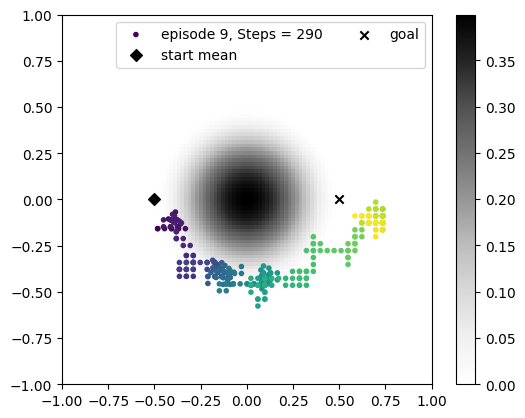

In [207]:
#Simulation
mu, sig = -0.5, 0.1
x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
agent = Agent(x,y).to(device)

t_agent = Agent(x,y).to(device)
t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
t_agent.eval()


optimizer = tr.optim.Adam(agent.parameters(), lr=0.001)




for i in range(epoch):
    epsilon = 1-(i/epoch)*0.7
    X,Y = episode(agent, t_agent, t_update, max_steps, g, optimizer,epsilon)
    agent.x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
    agent.y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
    
    

    if i%10 == 9:
        fig, ax = plt.subplots()
        x,y = X[agent.winner_index].detach().to('cpu').numpy(),Y[agent.winner_index].detach().to('cpu').numpy()
        print(i)
        ax.scatter(x,y,label='episode ' + str(int(i)) + ', Steps = '+str(len(x)),c=np.arange(len(x)),cmap='viridis',marker = '.')
        # U,V = force(X1,Y1)
        # plt.quiver(X1,Y1,U,V)

        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.scatter(-0.5,0,c='black',label='start mean',marker='D')    
        ax.scatter(0.5,0,c='black',label='goal',marker='x')
        ax.legend(ncol=2,loc='upper right')

        X1,Y1 = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
        Potential = U(0.4,X1,Y1)        
        img = ax.imshow(Potential,cmap = 'Greys',extent=[-1,1,-1,1],origin='lower')
        fig.colorbar(img)
        #fig.clim(Potential.min(),Potential.max())
        plt.title(str(agent.winner_index))
        plt.show()


In [ ]:
# X1,Y1 = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))  
# # U,V = force(X1,Y1)
# # plt.quiver(X1,Y1,U,V)
# Potential = U(0.4,X1,Y1)
# plt.imshow(Potential,cmap = 'Greys',extent=[-1,1,-1,1],origin='lower')
# plt.colorbar()
# plt.clim(Potential.min(),Potential.max())